In [ ]:
 !pip install treys

: 

In [ ]:
## Santi New Edits


import random
import treys
import pymc as pm
from treys import Deck
from treys import Card


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, players):
        self.players = players
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)
        self.round_id = 0


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
            print(player.evaluate_hand(self.board))
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    # def player_action(self, player):
    #     if not player.in_hand or player.money <= 0:
    #         self.fold(player)

    #     decision = random.randint(1,3)
    #     if decision == 1:
    #         self.fold(player)
    #         return "fold"
    #     elif decision == 2:
    #         if player.money >= self.current_bet - player.total_bet:
    #              self.call(player)
    #              return "call"
    #         else:
    #              self.fold(player)
    #              return "fold"

    #     else:
    #         if player.money >= self.current_bet + 1 - player.total_bet:
    #             self.raise_bet(player, 1)
    #             return "raise"


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            return "fold"

        hand_strength = player.evaluate_hand(self.board)
        hand_strength = (7462 - hand_strength)/7461
        # pot_odds = self.current_bet / (self.pot + self.current_bet + 1e-9)
        num_active_players = len([p for p in self.players if p.in_hand])

        # Model distributions for each opponent's hand based on their playing history
        opponent_distributions = []
        for opponent in self.players:
            if opponent != player and opponent.in_hand:
                # Build a Bayesian model for the opponent's hand strength
                with pm.Model() as opponent_model:
                    # Prior: Hand strength based on Treys system (1 to 7462)
                    prior_hand_strength = pm.Uniform(
                        f"{opponent.name}_hand_strength_prior_{self.round_id}",
                        lower=0,
                        upper=1,
                    )


                    for action in opponent.history:
                        aggressiveness = opponent.history.count("raise") / max(1, len(opponent.history))
                        passivity = opponent.history.count("call") / max(1, len(opponent.history))
                        if action == "raise":
                            # Aggressive players more likely to raise with weaker hands
                            pm.Potential(
                                f"{opponent.name}_raise_likelihood_{self.round_id}",
                                pm.math.log((1 - prior_hand_strength) * (1 + aggressiveness) + 0.1),
                            )
                        elif action == "call":
                            # Passive players more likely to call with stronger hands
                            pm.Potential(
                                f"{opponent.name}_call_likelihood_{self.round_id}",
                                pm.math.log(prior_hand_strength * (1 + passivity) + 0.1),
                            )

                    # Sample to estimate posterior
                    opponent_trace = pm.sample(100, tune=50, return_inferencedata=False, progressbar=False)

                    # Use the posterior mean as the distribution's central value
                    estimated_strength = opponent_trace[f"{opponent.name}_hand_strength_prior_{self.round_id}"].mean()
                    opponent_distributions.append((estimated_strength, 0.1))


        # Use Bayesian inference to combine information
        with pm.Model() as model:
            # Opponent hand strength priors
            opponent_hands = [
                pm.Normal(f"opponent_hand_{i}_{self.round_id}", mu=mu, sigma=sigma)
                for i, (mu, sigma) in enumerate(opponent_distributions)
            ]

            if opponent_hands:  # Ensure there are active opponents
                max_opponent_hand = pm.math.max(opponent_hands)
            else:
                max_opponent_hand = 0  # Default to 0 if no opponents

            win_prob = pm.math.sigmoid(hand_strength - max_opponent_hand)

            # Utility for fold, call, raise
            utility_fold = 0  # No loss or gain if folding
            utility_call = win_prob * (self.pot) - (1 - win_prob) * (self.current_bet - player.total_bet)
            utility_raise = (self.pot + self.current_bet) * win_prob - (2 * self.current_bet - player.total_bet) * (1-win_prob)

            # Decision probabilities
            decision_probs = pm.math.softmax([utility_fold, utility_call, utility_raise])
            decision = pm.Categorical(f"decision_{self.round_id}", p=decision_probs)

            trace = pm.sample(200, tune=100, cores=1, return_inferencedata=False, progressbar=False)



        # Get most probable decision
        decision = int(trace[f"decision_{self.round_id}"].mean())
        print(f"Decision: {decision}")
        if decision == 0:  # Fold
            self.fold(player)
            return "fold"
        elif decision == 1:  # Call
            if player.money >= self.current_bet - player.total_bet:
                  self.call(player)
                  return "call"
            else:
                  self.fold(player)
                  return "fold"
        elif decision == 2:  # Raise
            if player.money >= self.current_bet + 1 - player.total_bet:
                 self.raise_bet(player, 1)
                 return "raise"

    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = max(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        return winner

    def play_round(self):
        self.round_id += 1
        self.shuffle_deck()
        self.deal_cards()
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)

        # Loop until no raises
        active_players = self.players[:]
        new_bet = False
        while True:
            if new_bet:
                last_raiser = i-1
                new_bet = False
            else:
                last_raiser = 0
            for i in range(1, len(active_players)+1):
                if new_bet:
                    break
                active_players = [p for p in self.players if p.in_hand]
                if len(active_players) > 1:
                    player_index = (self.current_player_index + i + last_raiser) % len(active_players)
                    player = active_players[player_index]
                    action = self.player_action(player)
                    if action == "raise":
                        new_bet = True
                else:
                    new_bet = False
            if not new_bet:
                break

        # Determine winner
        winner = self.determine_winner()
        print("Alice", self.players[0].money, "Bob", self.players[1].money, "Charlie", self.players[2].money)
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while len([p for p in self.players if p.money > 0]) > 1:
            print(f"Starting a new round. Pot: ${self.pot}")
            winner = self.play_round()
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
players = [Player("Alice", 10), Player("Bob", 10), Player("Charlie", 10)]
game = GutsGame(players)
game.play_game()


In [ ]:
#model 1: purely win prob based
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  6 15:59:22 2024

@author: jackmarionsims
"""

import random
import treys
from treys import Deck
from treys import Card
from itertools import combinations


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, players):
        self.players = players
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
            print(player.evaluate_hand(self.board))
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def win_prob(self, player):
        evaluator = treys.Evaluator()
        test_deck = treys.Deck()
        for card in player.cards + self.board:
            test_deck.cards.remove(card)
        pos_opponent_hands = list(combinations(test_deck.cards, 2))
        hand_strength = player.evaluate_hand(self.board)
        wins = 0
        ties = 0
        losses = 0
        for opponent_hand in  pos_opponent_hands:
            opponent_strength = evaluator.evaluate(self.board, list(opponent_hand))
            if hand_strength < opponent_strength:
                wins += 1
            elif hand_strength == opponent_strength:
                ties += 1
            else:
                losses += 1

        total_scenarios = len(pos_opponent_hands)
        win_prob = wins / total_scenarios
        tie_prob = ties / total_scenarios
        loss_prob = losses / total_scenarios
        return (win_prob, tie_prob, loss_prob)

    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            self.fold(player)
        win_prob, tie_prob, lose_prob = self.win_prob(player)
        fold_ev = 0
        call_ev = (self.pot) * win_prob - (self.current_bet - player.total_bet) * lose_prob
        raise_ev = (self.pot + self.current_bet) * win_prob - (2 * self.current_bet - player.total_bet) * lose_prob
        print(fold_ev,call_ev, raise_ev)
        if win_prob < 0.4:
            self.fold(player)
            return "fold"
        elif win_prob < 0.6:
            if player.money >= self.current_bet - player.total_bet:
                 self.call(player)
                 return "call"
            else:
                 self.fold(player)
                 return "fold"

        else:
            if player.money >= self.current_bet + 1 - player.total_bet:
                self.raise_bet(player, 1)
                return "raise"
            elif player.money >= self.current_bet - player.total_bet:
                self.call(player)
                return "call"
            else:
                self.fold(player)
                return "fold"



    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = max(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        return winner

    def play_round(self):
        self.shuffle_deck()
        self.deal_cards()
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)

        # Loop until no raises
        active_players = self.players[:]
        while True:
            new_bet = False
            for i in range(1, len(active_players)+1):
                active_players = [p for p in self.players if p.in_hand]
                if len(active_players) > 1:
                    player_index = (self.current_player_index + i) % len(active_players)
                    player = active_players[player_index]
                    action = self.player_action(player)
                    if action == "raise":
                        new_bet = True
                else:
                    new_bet = False
            if not new_bet:
                break

        # Determine winner
        winner = self.determine_winner()
        print("Alice", self.players[0].money, "Bob", self.players[1].money, "Charlie", self.players[2].money)
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while len([p for p in self.players if p.money > 0]) > 1:
            print(f"Starting a new round. Pot: ${self.pot}")
            winner = self.play_round()
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
players = [Player("Alice", 10), Player("Bob", 10), Player("Charlie", 10)]
game = GutsGame(players)
game.play_round()



 [K♣],[9♥] 
1952
 [Q♦],[2♠] 
4528
 [7♦],[4♠] 
3032
 [9♠],[7♥],[6♦],[J♥],[9♦] 
0 -0.5747474747474748 -1.1494949494949496
0 0.9424242424242424 1.8303030303030303
0 0.6828282828282829 1.3656565656565658
0 3.2222222222222223 4.246464646464647
0 5.545454545454545 9.096969696969696
0 5.496969696969698 7.204040404040404
0 10.312121212121212 15.639393939393939
0 8.074747474747475 10.464646464646465
0 14.081818181818182 21.184848484848484
0 10.652525252525253 13.725252525252525
0 17.85151515151515 26.730303030303027
0 12.88888888888889 16.303030303030305
Alice 20 Bob 10 Charlie 0


In [ ]:
## Change to 2 Players
## Santi New Edits


import random
import treys
import pymc as pm
from treys import Deck
from treys import Card


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2
        self.players = [player1, player2]
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)
        self.round_id = 0


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
            print(player.evaluate_hand(self.board))
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            self.fold(player)

        decision = random.randint(1,3)
        if decision == 1:
            self.fold(player)
            return "fold"
        elif decision == 2:
            if player.money >= self.current_bet - player.total_bet:
                 self.call(player)
                 return "call"
            else:
                 self.fold(player)
                 return "fold"

        else:
            if player.money >= self.current_bet + 1 - player.total_bet:
                self.raise_bet(player, 1)
                return "raise"


    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = max(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        return winner

    def play_round(self):
        self.round_id += 1
        self.shuffle_deck()
        self.deal_cards()
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)
        first_turn = True
        curr_player = self.players[1-self.current_player_index]
        curr_idx = 1 - self.current_player_index
        new_bet = False
        while True:
            new_bet = False
            action = self.player_action(curr_player)
            if action == "raise":
                new_bet = True
                curr_idx = 1 - curr_idx
                curr_player = self.players[curr_idx]
            if not new_bet:
                if not first_turn or action =='fold':
                    break
                else:
                    first_turn = False
                    curr_idx = 1 - curr_idx
                    curr_player = self.players[curr_idx]
            first_turn = False

        # Determine the winner
        winner = self.determine_winner()
        print(f"Winner of this round: {winner.name} with ${winner.money}")
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while all(p.money > 0 for p in self.players):
            print(f"Starting a new round. Pot: ${self.pot}")
            winner = self.play_round()
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
player1 = Player("Alice", 10)
player2 = Player("Bob", 10)
game = GutsGame(player1,player2)
game.play_game()


-0.018418560606060615 0.004476052577144553
-0.004210858585858578 0.004677911373839405


Output()

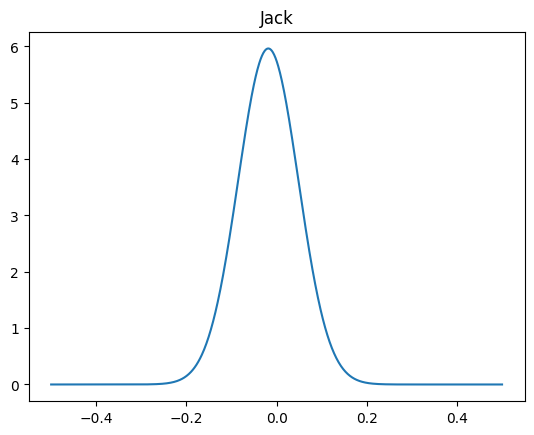

In [ ]:
#game data
import treys
import pymc as pm
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from treys import Deck, Evaluator, Card
from itertools import combinations

santi_winprobs = [0.2, 0.1, 0.7, 0.15, 0.25, 0.4, 0.9, 0.3, 0.1, 0.2, 0.1, 0.85, 0.6, 0.15, 0.25,
                  0.55, 0.9, 0.55, 0.8, 0.99, 0.75, 0.85, 0.3, 0.4, 0.25, 0.25, 0.55, 0.6, 0.15, 0.95, 0.1, 0.95]
santi_money = [10,11,9,9,9,5,7,1,10,10,9,9,9,10,8,9,9,13,14,16,18,19,19,19,18,16,16,17,17,15,19,19]
santi_hands = []
santi_hands.append([Card.new('Qc'), Card.new('9s')])
santi_hands.append([Card.new('4c'), Card.new('7c')])
santi_hands.append([Card.new('Qs'), Card.new('2s')])
santi_hands.append([Card.new('6h'), Card.new('7c')])
santi_hands.append([Card.new('2c'), Card.new('7s')])
santi_hands.append([Card.new('Ad'), Card.new('Tc')])
santi_hands.append([Card.new('Jd'), Card.new('3c')])
santi_hands.append([Card.new('9h'), Card.new('Jh')])

jack_winprobs = [0.1, 0.80, 0.03, 0.9, 0.6, 0.02, 0.5, 0.5, 0.25, 0.75, 0.8, 0.2, 0.35, 0.5,0.02, 0.35, 0.7,
                 0.03, 0.4, 0.05, 0.30, 0.50, 0.97, 0.97, 0.3, 0.05, 0.02, 0.05, 0.99, 0.65, 0.5, 0.6]
jack_money = [10,9,11,11,11,15,13,19,10,10,11,11,11,10,12,11,11,7,6,4,2,1,1,1,2,4,4,3,3,5,1,1]
jack_hands = []
jack_hands.append([Card.new('Th'), Card.new('7s')])
jack_hands.append([Card.new('6c'), Card.new('6s')])
jack_hands.append([Card.new('8h'), Card.new('2d')])
jack_hands.append([Card.new('8c'), Card.new('2d')])
jack_hands.append([Card.new('Ks'), Card.new('3d')])
jack_hands.append([Card.new('7c'), Card.new('6c')])
jack_hands.append([Card.new('2c'), Card.new('6s')])
jack_hands.append([Card.new('Kh'), Card.new('4d')])


boards = []
boards.append([Card.new('6d'), Card.new('Jd'), Card.new('2h'), Card.new('Jh'), Card.new('Ks')])
boards.append([Card.new('9d'), Card.new('Js'), Card.new('Kd'), Card.new('6h'), Card.new('Ts')])
boards.append([Card.new('Qd'), Card.new('7d'), Card.new('6c'), Card.new('6d'), Card.new('Js')])
boards.append([Card.new('5c'), Card.new('Js'), Card.new('Tc'), Card.new('2c'), Card.new('2h')])
boards.append([Card.new('3s'), Card.new('5c'), Card.new('4s'), Card.new('Jh'), Card.new('4h')])
boards.append([Card.new('9s'), Card.new('Qc'), Card.new('Kc'), Card.new('3s'), Card.new('8h')])
boards.append([Card.new('Jc'), Card.new('4c'), Card.new('8c'), Card.new('6h'), Card.new('3s')])
boards.append([Card.new('4s'), Card.new('3h'), Card.new('8d'), Card.new('7d'), Card.new('Ac')])

game2 = [
    ("QD,6H,6C,KS,TD", "8S,2S", "JC, 5C"),
    ("8C,TD,AD,4C,7D", "QS,5D", "AC, 6D"),
    ("QD,9H,AH,KH,JD", "8H,3S", "AC, QH"),
    ("JD,8D,6C,QD,7H", "JC,QC", "KH, 9C"),
    ("6C,TH,JH,2D,TS", "8S,8D", "AH, 5D"),
    ("9H,7H,QH,7D,KH", "6C,TD", "9C, 3D"),
    ("2H,QD,TD,QH,QC", "AD,7C", "3D, 5D"),
    ("JS,AC,6D,8S,8C", "6H,3S", "KC, 3H"),
    ("3H,4S,QC,8D,QH", "QD,7H", "8C, 5H"),
    ("KD,4H,TC,QC,9H", "8H,9C", "8S, 5C"),
    ("JH,8D,9H,8S,5C", "KS,JC", "AC, KC"),
    ("TS,TC,7C,QC,6H", "7H,TD", "9D, 3S"),
    ("5C,9H,AC,6H,8S", "AH,4H", "KC, JC"),
    ("2H,QD,7C,TC,4C", "7D,TD", "8D, 2S"),
    ("2D,2C,8D,3H,9D", "AH,4D", "JD, 7D"),
    ("AC,2S,JD,TH,JH", "4H,2H", "JC, 8S"),
    ("6D,KS,QS,3S,JS", "3H,2D", "7D, 6C"),
    ("7D,JS,8S,5H,5C", "AS,3C", "TH, 2H"),
    ("9S,5S,KD,TS,AH", "9D,QS", "6H, 4C"),
    ("TC,5D,7H,8H,2D", "QH,5H", "9C, 3S"),
    ("AC,3D,6S,9C,5D", "QC,2D", "4H, 2H"),
    ("4D,4C,7C,2C,JH", "9C,3C", "7S, 9H"),
    ("9D,JC,2H,6H,4D", "8C,5D", "2C, 7H"),
    ("KC,2H,7C,7D,4D", "7H,5H", "3H, 4C"),
]

# Function to convert card strings to Treys card objects
def parse_cards(card_string):
    return [Card.new(card.strip()[0]+card.strip()[1].lower()) for card in card_string.split(',')]

# Parsing data into separate lists

for board, hand1, hand2 in game2:
    boards.append(parse_cards(board))
    santi_hands.append(parse_cards(hand1))
    jack_hands.append(parse_cards(hand2))

def win_prob(player_name):
  probs = []
  evaluator = treys.Evaluator()
  for i in range(len(boards)):
    test_deck = treys.Deck()
    for card in boards[i]:
      test_deck.cards.remove(card)
    if player_name == "Jack":
      hand_strength = evaluator.evaluate(boards[i], jack_hands[i])
      for card in jack_hands[i]:
        test_deck.cards.remove(card)
    else:
      hand_strength = evaluator.evaluate(boards[i], santi_hands[i])
      for card in santi_hands[i]:
        test_deck.cards.remove(card)
    pos_opponent_hands = list(combinations(test_deck.cards, 2))
    wins = 0
    ties = 0
    losses = 0
    for opponent_hand in  pos_opponent_hands:
        opponent_strength = evaluator.evaluate(boards[i], list(opponent_hand))
        if hand_strength < opponent_strength:
            wins += 1
        elif hand_strength == opponent_strength:
            ties += 1
        else:
            losses += 1
    total_scenarios = len(pos_opponent_hands)
    win_prob = wins / total_scenarios
    tie_prob = ties / total_scenarios
    loss_prob = losses / total_scenarios
    probs.append(win_prob)
  return probs


real_jack_winprobs = win_prob("Jack")
result_jack = [x - y for x, y in zip(jack_winprobs, real_jack_winprobs)]
jack_mean = sum(result_jack)/32
jack_var = sum((jack_mean - i)**2 for i in result_jack)/32
print(jack_mean, jack_var)
jack_sd = jack_var**(0.5)

real_santi_winprobs = win_prob("Santi")
result_santi = [x - y for x, y in zip(santi_winprobs, real_santi_winprobs)]
santi_mean = sum(result_santi)/32
santi_var = sum((santi_mean - i)**2 for i in result_jack)/32
print(santi_mean, santi_var)
santi_sd = santi_var**(0.5)

with pm.Model() as model:
    jack_normal = pm.Normal("jack_normal", mu=jack_mean, sigma=jack_sd)
    santi_normal = pm.Normal("santi_normal", mu=santi_mean, sigma=santi_sd)
    trace = pm.sample(2000, return_inferencedata=True, cores=2)

# Extract samples
jack_samples = trace.posterior["jack_normal"].values.flatten()
santi_samples = trace.posterior["santi_normal"].values.flatten()

'''
normal_draw = pm.draw(jack_normal, 100)
print(normal_draw)
'''

x = np.linspace(-0.5, 0.5, 1000)
pdf = st.norm.pdf(x, jack_mean, jack_sd)
plt.plot(x, pdf)
plt.title("Jack")
plt.show()



In [77]:
#Model 1
import random
import treys
import pymc as pm
from treys import Deck
from treys import Card


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2
        self.players = [player1, player2]
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)
        self.round_id = 0


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
        Card.print_pretty_cards(self.board)

    def real_game(self, board, player1hand, player2hand):
        self.board = board
        for player in self.players:
            player.reset()
        self.player1.cards = player1hand
        self.player2.cards = player2hand
        all_used = board + player1hand + player2hand
        for card in all_used:
            self.deck.cards.remove(card)
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def win_prob(self, player):
        evaluator = treys.Evaluator()
        test_deck = treys.Deck()
        for card in player.cards + self.board:
            test_deck.cards.remove(card)
        pos_opponent_hands = list(combinations(test_deck.cards, 2))
        hand_strength = player.evaluate_hand(self.board)
        wins = 0
        ties = 0
        losses = 0
        for opponent_hand in  pos_opponent_hands:
            opponent_strength = evaluator.evaluate(self.board, list(opponent_hand))
            if hand_strength < opponent_strength:
                wins += 1
            elif hand_strength == opponent_strength:
                ties += 1
            else:
                losses += 1

        total_scenarios = len(pos_opponent_hands)
        win_prob = wins / total_scenarios
        tie_prob = ties / total_scenarios
        loss_prob = losses / total_scenarios
        return (win_prob, tie_prob, loss_prob)

    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            self.fold(player)
        win_prob, tie_prob, lose_prob = self.win_prob(player)
        fold_ev = 0
        call_ev = (self.pot) * win_prob - (self.current_bet - player.total_bet) * lose_prob
        raise_ev = (self.pot + self.current_bet) * win_prob - (2 * self.current_bet - player.total_bet) * lose_prob
        #print(fold_ev,call_ev, raise_ev)
        if win_prob < 0.4:
            self.fold(player)
            return "fold"
        elif win_prob < 0.6:
            if player.money >= self.current_bet - player.total_bet:
                 self.call(player)
                 return "call"
            else:
                 self.fold(player)
                 return "fold"

        else:
            if player.money >= self.current_bet + 1 - player.total_bet:
                self.raise_bet(player, 1)
                return "raise"
            elif player.money >= self.current_bet - player.total_bet:
                self.call(player)
                return "call"
            else:
                self.fold(player)
                return "fold"


    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = min(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        print(winner)
        return winner

    def play_round(self, number):
        self.round_id += 1
        self.shuffle_deck()
        self.real_game(boards[number], santi_hands[number], jack_hands[number])
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)
        first_turn = True
        curr_player = self.players[1-self.current_player_index]
        curr_idx = 1 - self.current_player_index
        new_bet = False
        while True:
            new_bet = False
            action = self.player_action(curr_player)
            print(starting_player.name, curr_player.name, action)
            if action == "raise":
                new_bet = True
                curr_idx = 1 - curr_idx
                curr_player = self.players[curr_idx]
            if not new_bet:
                if not first_turn or action =='fold':
                    break
                else:
                    first_turn = False
                    curr_idx = 1 - curr_idx
                    curr_player = self.players[curr_idx]
            first_turn = False

        # Determine the winner
        winner = self.determine_winner()
        print(f"Winner of this round: {winner.name} with ${winner.money}")
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while all(p.money > 0 for p in self.players):
            print(f"Starting a new round. Pot: ${self.pot}")
            for i in range(9):
              winner = self.play_round(i)
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
player1 = Player("Santi", 10)
player2 = Player("Jack", 10)
game = GutsGame(player1,player2)
for i in range(32):
  game.player1.money = santi_money[i]
  game.player2.money = jack_money[i]
  game.play_round(i)




 [6♦],[J♦],[2♥],[J♥],[K♠] 
Jack fold
Winner of this round: Santi with $10
 [9♦],[J♠],[K♦],[6♥],[T♠] 
Santi fold
Winner of this round: Jack with $9
 [Q♦],[7♦],[6♣],[6♦],[J♠] 
Jack fold
Winner of this round: Santi with $9
 [5♣],[J♠],[T♣],[2♣],[2♥] 
Santi fold
Winner of this round: Jack with $11
 [3♠],[5♣],[4♠],[J♥],[4♥] 
Jack call
Santi fold
Winner of this round: Jack with $12
 [9♠],[Q♣],[K♣],[3♠],[8♥] 
Santi fold
Winner of this round: Jack with $15
 [J♣],[4♣],[8♣],[6♥],[3♠] 
Jack call
Santi raise
Jack call
Winner of this round: Santi with $9
 [4♠],[3♥],[8♦],[7♦],[A♣] 
Santi fold
Winner of this round: Jack with $19
 [Q♦],[6♥],[6♣],[K♠],[T♦] 
Jack fold
Winner of this round: Santi with $10
 [8♣],[T♦],[A♦],[4♣],[7♦] 
Santi fold
Winner of this round: Jack with $10
 [Q♦],[9♥],[A♥],[K♥],[J♦] 
Jack raise
Santi fold
Winner of this round: Jack with $12
 [J♦],[8♦],[6♣],[Q♦],[7♥] 
Santi raise
Jack fold
Winner of this round: Santi with $10
 [6♣],[T♥],[J♥],[2♦],[T♠] 
Jack call
Santi raise
Jack call
W

In [ ]:
#Model 2
import random
import treys
import pymc as pm
from treys import Deck
from treys import Card


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2
        self.players = [player1, player2]
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)
        self.round_id = 0


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
        Card.print_pretty_cards(self.board)

    def real_game(self, board, player1hand, player2hand):
        self.board = board
        for player in self.players:
            player.reset()
        self.player1.cards = player1hand
        self.player2.cards = player2hand
        all_used = board + player1hand + player2hand
        for card in all_used:
            self.deck.cards.remove(card)
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def win_prob(self, player):
        evaluator = treys.Evaluator()
        test_deck = treys.Deck()
        for card in player.cards + self.board:
            test_deck.cards.remove(card)
        pos_opponent_hands = list(combinations(test_deck.cards, 2))
        hand_strength = player.evaluate_hand(self.board)
        wins = 0
        ties = 0
        losses = 0
        for opponent_hand in  pos_opponent_hands:
            opponent_strength = evaluator.evaluate(self.board, list(opponent_hand))
            if hand_strength < opponent_strength:
                wins += 1
            elif hand_strength == opponent_strength:
                ties += 1
            else:
                losses += 1

        total_scenarios = len(pos_opponent_hands)
        win_prob = wins / total_scenarios
        tie_prob = ties / total_scenarios
        loss_prob = losses / total_scenarios
        return (win_prob, tie_prob, loss_prob)

    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            self.fold(player)
        win_prob, tie_prob, lose_prob = self.win_prob(player)
        fold_ev = 0
        call_ev = (self.pot) * win_prob - (self.current_bet - player.total_bet) * lose_prob
        raise_ev = (self.pot + self.current_bet) * win_prob - (2 * self.current_bet - player.total_bet) * lose_prob
        if player.name == "Jack":
          jack_fold = (jack_samples < 0.4 - win_prob).mean()
          jack_call = ((0.4 - win_prob < jack_samples) & (jack_samples < 0.6 - win_prob)).mean()
          jack_raise = (jack_samples > 0.6 - win_prob).mean()
          values = [jack_fold, jack_call, jack_raise]
          normal_draw = pm.draw(jack_normal)
        else:
          santi_fold = (santi_samples < 0.4 - win_prob).mean()
          santi_call = ((0.4 - win_prob < santi_samples) & (santi_samples < 0.6 - win_prob)).mean()
          santi_raise = (santi_samples > 0.6 - win_prob).mean()
          values = [santi_fold, santi_call, santi_raise]
          normal_draw = pm.draw(santi_normal)
        santi_greater = (santi_samples > 0.1).mean()
        labels = ["Fold", "Call", "Raise"]
        plt.bar(labels, values, color=["blue", "orange", "red"])
        plt.ylabel("Proportion")
        if player.name == "Jack":
          plt.title("Jack Probability of each Action")
        else:
          plt.title("Santi Probability of each Action")
        plt.ylim(0, 1)
        plt.show()
        #print(fold_ev,call_ev, raise_ev)
        win_prob += normal_draw
        if win_prob < 0.4:
            self.fold(player)
            return "fold"
        elif win_prob < 0.6:
            if player.money >= self.current_bet - player.total_bet:
                 self.call(player)
                 return "call"
            else:
                 self.fold(player)
                 return "fold"

        else:
            if player.money >= self.current_bet + 1 - player.total_bet:
                self.raise_bet(player, 1)
                return "raise"
            elif player.money >= self.current_bet - player.total_bet:
                self.call(player)
                return "call"
            else:
                self.fold(player)
                return "fold"


    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = min(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        print(winner)
        return winner

    def play_round(self, number):
        self.round_id += 1
        self.shuffle_deck()
        self.real_game(boards[number], santi_hands[number], jack_hands[number])
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)
        first_turn = True
        curr_player = self.players[1-self.current_player_index]
        curr_idx = 1 - self.current_player_index
        new_bet = False
        while True:
            new_bet = False
            action = self.player_action(curr_player)
            if action == "raise":
                new_bet = True
                curr_idx = 1 - curr_idx
                curr_player = self.players[curr_idx]
            if not new_bet:
                if not first_turn or action =='fold':
                    break
                else:
                    first_turn = False
                    curr_idx = 1 - curr_idx
                    curr_player = self.players[curr_idx]
            first_turn = False

        # Determine the winner
        winner = self.determine_winner()
        print(f"Winner of this round: {winner.name} with ${winner.money}")
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while all(p.money > 0 for p in self.players):
            print(f"Starting a new round. Pot: ${self.pot}")
            for i in range(9):
              winner = self.play_round(i)
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
player1 = Player("Santi", 10)
player2 = Player("Jack", 10)
game = GutsGame(player1,player2)
for i in range(8):
  game.player1.money = santi_money[i]
  game.player2.money = jack_money[i]
  game.play_round(i)




In [ ]:
# Santi, creating function to adjust probabilities

import random
import numpy as np
import treys
import pymc as pm
from treys import Deck
from treys import Card


class Player:
    def __init__(self, name, money):
        self.name = name
        self.money = money
        self.cards = []
        self.in_hand = True  # Whether the player is still in the hand
        self.total_bet = 0
        self.history = []

    def reset(self):
        self.cards = []
        self.in_hand = True
        self.total_bet = 0
        self.history = []

    def make_bet(self, amount):
        self.total_bet += amount
        self.money -= amount


    def evaluate_hand(self, board):
        """Evaluate the strength of the hand. Higher value means stronger hand."""
        # Simplified: sum of card values (can be replaced with more advanced logic)
        evaluator = treys.Evaluator()
        return evaluator.evaluate(board, self.cards)

class GutsGame:
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2
        self.players = [player1, player2]
        self.pot = 0
        self.current_bet = 0
        self.current_player_index = 0
        self.deck = treys.Deck()
        self.board = self.deck.draw(5)
        self.round_id = 0


    def shuffle_deck(self):
        self.deck = treys.Deck()

    def deal_cards(self):
        self.board = self.deck.draw(5)
        for player in self.players:
            player.reset()
            player.cards = self.deck.draw(2)
            Card.print_pretty_cards(player.cards)
        Card.print_pretty_cards(self.board)

    def real_game(self, board, player1hand, player2hand):
        self.board = board
        for player in self.players:
            player.reset()
        self.player1.cards = player1hand
        self.player2.cards = player2hand
        all_used = board + player1hand + player2hand
        for card in all_used:
            self.deck.cards.remove(card)
        Card.print_pretty_cards(self.board)

    def raise_bet(self, player, amount):
        amount_added = self.current_bet + amount - player.total_bet
        self.pot += amount_added
        self.current_bet += amount
        player.make_bet(amount_added)

    def call(self, player):
        amount_added = self.current_bet - player.total_bet
        self.pot += amount_added
        player.make_bet(amount_added)

    def fold(self, player):
        player.in_hand = False

    def win_prob(self, player):
        evaluator = treys.Evaluator()
        test_deck = treys.Deck()
        for card in player.cards + self.board:
            test_deck.cards.remove(card)
        pos_opponent_hands = list(combinations(test_deck.cards, 2))

        hand_strength = player.evaluate_hand(self.board)
        wins = 0
        ties = 0
        losses = 0
        all_strengths = []
        for opponent_hand in  pos_opponent_hands:
            opponent_strength = evaluator.evaluate(self.board, list(opponent_hand))
            all_strengths.append(opponent_strength)
            if hand_strength < opponent_strength:
                wins += 1
            elif hand_strength == opponent_strength:
                ties += 1
            else:
                losses += 1
        all_strengths = np.array(all_strengths)
        all_probabilities = [1/len(all_strengths)]*len(all_strengths)
        all_probabilities = np.array(all_probabilities)

        total_scenarios = len(pos_opponent_hands)
        win_prob = wins / total_scenarios
        tie_prob = ties / total_scenarios
        loss_prob = losses / total_scenarios
        return (win_prob, tie_prob, loss_prob,all_strengths,all_probabilities)

    def call_update(self,player, hands, probabilities):
        q1, q3 = np.percentile(hands, [25, 75])

        q1_indices = hands < q1
        q4_indices = hands > q3
        q2_q3_indices = ~q1_indices & ~q4_indices

        lost_prob = np.sum(probabilities[q1_indices]) / 2 + np.sum(probabilities[q4_indices]) / 2


        probabilities[q1_indices] /= 2
        probabilities[q4_indices] /= 2


        probabilities[q2_q3_indices] += lost_prob / np.sum(q2_q3_indices)


        assert np.isclose(np.sum(probabilities), 1.0), "Probabilities do not sum to 1!"

        return probabilities

    def raise_update(player, hands, probabilities):
        q1, q3 = np.percentile(hands, [25, 75])
        median = np.median(hands)

        q1_q2_indices = hands < median
        q3_indices = (hands >= median) & (hands <= q3)
        q4_indices = hands > q3

        lost_prob = (
            np.sum(probabilities[q1_q2_indices]) * (3 / 4)
            + np.sum(probabilities[q3_indices]) * (1 / 2)
        )

        probabilities[q1_q2_indices] *= (1 / 4)
        probabilities[q3_indices] *= (1 / 2)


        probabilities[q4_indices] += lost_prob / np.sum(q4_indices)

        assert np.isclose(np.sum(probabilities), 1.0)

        return probabilities


    def rotate_starting_player(self):
        self.current_player_index = (self.current_player_index + 1) % len(self.players)


    def player_action(self, player):
        if not player.in_hand or player.money <= 0:
            self.fold(player)
        win_prob, tie_prob, lose_prob = self.win_prob(player)
        fold_ev = 0
        call_ev = (self.pot) * win_prob - (self.current_bet - player.total_bet) * lose_prob
        raise_ev = (self.pot + self.current_bet) * win_prob - (2 * self.current_bet - player.total_bet) * lose_prob
        #print(fold_ev,call_ev, raise_ev)
        if win_prob < 0.4:
            self.fold(player)
            return "fold"
        elif win_prob < 0.6:
            if player.money >= self.current_bet - player.total_bet:
                 self.call(player)
                 return "call"
            else:
                 self.fold(player)
                 return "fold"

        else:
            if player.money >= self.current_bet + 1 - player.total_bet:
                self.raise_bet(player, 1)
                return "raise"
            elif player.money >= self.current_bet - player.total_bet:
                self.call(player)
                return "call"
            else:
                self.fold(player)
                return "fold"


    def determine_winner(self):
        active_players = [p for p in self.players if p.in_hand]
        if not active_players:
            return None

        winner = max(active_players, key=lambda p: p.evaluate_hand(self.board))
        winner.money += self.pot
        self.pot = 0
        print(winner)
        return winner

    def play_round(self, number):
        self.round_id += 1
        self.shuffle_deck()
        self.real_game(boards[number], santi_hands[number], jack_hands[number])
        self.pot = 0
        self.current_bet = 0

        # Starting player bets $1
        starting_player = self.players[self.current_player_index]
        if starting_player.money >= 1:
            self.raise_bet(starting_player, 1)
        first_turn = True
        curr_player = self.players[1-self.current_player_index]
        curr_idx = 1 - self.current_player_index
        new_bet = False
        while True:
            new_bet = False
            action = self.player_action(curr_player)
            if action == "raise":
                new_bet = True
                curr_idx = 1 - curr_idx
                curr_player = self.players[curr_idx]
            if not new_bet:
                if not first_turn or action =='fold':
                    break
                else:
                    first_turn = False
                    curr_idx = 1 - curr_idx
                    curr_player = self.players[curr_idx]
            first_turn = False

        # Determine the winner
        winner = self.determine_winner()
        print(f"Winner of this round: {winner.name} with ${winner.money}")
        self.rotate_starting_player()
        return winner

    def play_game(self):
        while all(p.money > 0 for p in self.players):
            print(f"Starting a new round. Pot: ${self.pot}")
            for i in range(9):
              winner = self.play_round(i)
            if winner:
                print(f"{winner.name} wins the pot! Current money: {winner.money}")

        winner = max(self.players, key=lambda p: p.money)
        print(f"Game over! The winner is {winner.name} with ${winner.money}")

# Example usage
player1 = Player("Santi", 10)
player2 = Player("Jack", 10)
game = GutsGame(player1,player2)
game.play_round(0)



 [6♦],[J♦],[2♥],[J♥],[K♠] 


ValueError: too many values to unpack (expected 3)